In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.gym.atari.KungFuMaster-v0.cnn"
snapshot_path = "."


#gym game title
GAME_TITLE = 'KungFuMaster-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 10


#how long is one replay session from a batch

#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 25

In [2]:
#this is my machine-specific config. replace if are not me.

#theano device selection
%env THEANO_FLAGS='device=gpu2'


#snapshot path - where neural network snapshots are saved during the main training loop
!mkdir ./agentnet_snapshots/
snapshot_path = "./agentnet_snapshots/"


env: THEANO_FLAGS='device=gpu2'
mkdir: cannot create directory './agentnet_snapshots/': File exists


# This tutorial is a showcase on how to use advanced AgentNet techniques 


# [new]

* The notebook is mostly based on "Playing atari with Deep Reinforcement Learning (OpenAI Gym)" example
 * All changes against that example will be marked with #[new] sign, like one above
* We use a recurrent memory layer, implemented via Gated Recurrent Unit
* We use advantage actor-critic method to train agent (using policy + state values instead of q-values)
* We train agent to hurt humans in KungFu master game
* We also use a bit heavier a network to process inputs (~convolutional from basic example)
  * If you have no GPU and want agent to train faster than human child, replace it with what worked in basic example

## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports

import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [4]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game

[2016-05-16 11:49:55,748] Making new env: KungFuMaster-v0


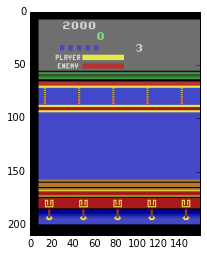

In [5]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [6]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print(action_names)

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [7]:
del atari

# agent setup step by step
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * chooses what action to take given Q-values
   * in this case, the resolver has epsilon-greedy policy
  




##### Agent observations

* Here you define where observations (game images) appear in the network
* You can use any lasagne architecture you want. We provide several examples

In [8]:
import lasagne

from lasagne.layers import InputLayer,DropoutLayer,DenseLayer, ExpressionLayer, Conv2DLayer,MaxPool2DLayer
from lasagne.layers import flatten, dimshuffle

In [9]:


#image observation
observation_layer = lasagne.layers.InputLayer(observation_shape,
                                                    name="images input")

observation_reshape = lasagne.layers.dimshuffle(observation_layer,(0,3,1,2))



# [ part where heavy convolutional network is defined]
#if you have to GPU, consider something lighter

#conv
cnn = Conv2DLayer(observation_reshape, num_filters=32,filter_size=(5,5),name='conv0')
cnn = Conv2DLayer(cnn, num_filters=32,filter_size=(5,5),name='conv1')
cnn = MaxPool2DLayer(cnn,(5,5))

#dense with dropout    
dnn = DenseLayer(cnn,num_units=500,name='dense0')
dnn = DropoutLayer(dnn,name = "dropout", p=0.05) #will get deterministic during evaluation
dnn = DenseLayer(dnn,num_units=300,name='dense1')

# [end of that part]

inp_nn = dnn

  
### Agent memory states
 * Here you can define arbitrary transitions between "previous state" variables and their next states
 * The rules are
   * previous states must be input layers
   * next states must have same shape as previous ones
   * otherwise it can be any lasagne network
   * AgentNet.memory has several useful layers
   
 * During training and evaluation, your states will be updated recurrently
   * next state at t=1 is given as previous state to t=2
 
 * Finally, you have to define a dictionary mapping new state -> previous state


Atari game environments are known to have __flickering__ effect where some sprites are shown only on odd frames and others on even ones - that was used to optimize performance at the time.

To compensate for this, we shall use the memory layer called __WindowAugmentation__ which basically maintains a K previous time steps of what it is fed with.


# [new]
We shall also use a GRUMemoryLayer to represent agent's recurrent memory state. This state is updated on every turn given window state.
Not that this is __not the same__ as `lasagne.layers.GRULayer` as GRUMemoryLayer only does a single time tick (lasagne version iterates over the whole sequence).



In [10]:

#memory
#using simple window-based memory that stores several states
#the SpaceInvaders environment does not need any more as it is almost fully-observed
from agentnet.memory import WindowAugmentation, GRUMemoryLayer


#our window
window_size = 3
prev_window = InputLayer((None,window_size,inp_nn.output_shape[1]),
                                        name = "previous window state")

window = WindowAugmentation(inp_nn,prev_window,name = "new window state")



# first (and so far only) GRU layer

gru0_size = 256

prev_gru0 = InputLayer((None,gru0_size),name="previous GRU0 state")

#neuron-wise maxima of window frames as an input to the GRU
window_max = ExpressionLayer(window,function=lambda v: v.max(axis=1), 
                             output_shape=inp_nn.output_shape,
                             name = 'window_max')


window_max = lasagne.layers.FeaturePoolLayer(window,window_size)

gru0 = GRUMemoryLayer(gru0_size,
                      observation_input = window_max,
                      prev_state_input = prev_gru0,
                      name="gru0"
                  )



#a dictionary that maps next agent memory states to previous ones
from collections import OrderedDict
memory_dict = OrderedDict([(window,prev_window),
                           (gru0,prev_gru0)])



##### Agent policy and action picking


# [new]

* Since we are using Actor-Critic method, we need to predict 2 values:
  * State value - basicly a Q-value of best action in a state
  * Agent policy - probabilities of taking actions
  

* To pick actions, we use a probablistic resolver
  * That one picks actions with given probabilities
  * We use a laplacian smoothing to pick actions in training (to bolster exploration) 
  * The resolver output is considered agent's next action and sent into the environment

In [11]:
#State values
state_value_layer = DenseLayer(gru0,
                               num_units = 1,
                               nonlinearity = lasagne.nonlinearities.linear,
                               name = "Vpredicted")


#a2c probabilities


policy_layer_pre_softmax = DenseLayer(gru0,
                                     num_units = n_actions,
                                     nonlinearity= None,
                                     name="policy_original")


from lasagne.layers import NonlinearityLayer
policy_layer = NonlinearityLayer(policy_layer_pre_softmax,
                                 lasagne.nonlinearities.softmax)


#actual action probablilities
epsilon = theano.shared(np.float32(0.1),"epsilon")


#add laplacian smoothing
smooth_policy_layer = NonlinearityLayer(
    policy_layer_pre_softmax,
    lambda v: lasagne.nonlinearities.softmax(v*(1.-epsilon) + epsilon/n_actions)
)





#resolver

from agentnet.resolver import ProbablisticResolver


resolver = ProbablisticResolver(smooth_policy_layer,assume_normalized=True,name="resolver")



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

# [new]
* Note that we can have any (incl. none) number of agent policy variables,
* so you can use that to track any layer output
* It is also possible to have multiple observations and actions, but that's not aplicable to Atari environment

In [12]:
from agentnet.agent import Agent


#all together
agent = Agent(observation_layer,
              memory_dict,
              [policy_layer,state_value_layer],
              resolver)


In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((resolver,state_value_layer),trainable=True)
weights

[conv0.W,
 conv0.b,
 conv1.W,
 conv1.b,
 dense0.W,
 dense0.b,
 dense1.W,
 dense1.b,
 gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 policy_original.W,
 policy_original.b,
 Vpredicted.W,
 Vpredicted.b]

# Agent step function

* A function that makes a single agent turn
  * converts (observation, prev_memories) -> action, new_memories

In [14]:
#compile theano graph
applier_fun = agent.get_react_function()

#a nice pythonic interface
def step(observation, prev_memories = 'zeros',batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype=floatX) 
                         for mem in agent.state_variables]
    
    res = applier_fun(np.array(observation),*prev_memories)
    action = res[0]
    memories = res[1:]
    return action,memories

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening in parallel
* We define a thin wrapper that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
 * a function to generate interaction sessions
* This allows us to instantly continue a session from where it stopped



The wrapper itself is a class with a single method that creates interaction sessions. It can be found at examples/openai_gym_pool.py


Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [15]:
from openai_gym_pool import GamePool
pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)

[2016-05-16 11:49:58,068] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,108] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,147] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,187] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,226] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,264] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,303] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,341] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,380] Making new env: KungFuMaster-v0
[2016-05-16 11:49:58,420] Making new env: KungFuMaster-v0


In [16]:
%%time

observation_log,action_log,reward_log,_,_,_  = pool.interact(step,50)

#sanity check: random actions
print(np.array(action_names)[np.array(action_log)[:3,:5]])

[['LEFTFIRE' 'NOOP' 'DOWNRIGHT' 'DOWNLEFTFIRE' 'LEFTFIRE']
 ['NOOP' 'LEFTFIRE' 'UP' 'DOWNLEFTFIRE' 'RIGHT']
 ['NOOP' 'DOWNRIGHT' 'DOWNFIRE' 'DOWNRIGHT' 'NOOP']]
CPU times: user 2.59 s, sys: 552 ms, total: 3.14 s
Wall time: 3.28 s


# experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [17]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.state_variables.keys())

In [18]:
def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    #get interaction sessions
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(step,n_steps=n_steps)
        
    #load them into experience replay environment
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
    

In [19]:
#load first  sessions
update_pool(env,pool,replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (reinforcement learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

# [new]
* Note that we not unpack several variables (policy, values) instead of Q-values
* We than reshape V_seq from (batch, time, 1 unit) intp (batch_time)

In [20]:
#replay interaction sequences of length <= replay_seq_len

_,observation_seq,_,_,(policy_seq,V_seq) = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True
)




#observation seq are the observation tensor we just loaded
#policy seq are agent action probabilities predicted within experience replay
# V_seq are agent state values

#The three "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now


#reshape V_seq from (batch, time, 1 unit) intp (batch_time)
V_seq = V_seq[:,:,0]


#the actions agent took in the original recorded game
action_seq = env.actions[0]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = env.is_alive


# Evaluating loss function

# [new]
* In this part we are using an n-step Advantage Actor-Critic (A2c)
* In this case, it's a 10-step a2c (see n_steps parameter)
* To use Q-learning or sarsa, you will have to predict Q-values instead of probabilities

* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - actor-critic loss function)
  * $ log {\pi} \cdot (V_{percieved} - V_{predicted}) $
  * $\pi$ is agent policy, $V$'s are state values
  * Read more at http://www.arxiv.org/pdf/1602.01783v1.pdf
    
* If you want to do it the hard way instead, try .get_reference_state_values and compute errors on ya own
  

In [21]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import a2c_n_step

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.99),name = 'q_learning_gamma')


#IMPORTANT!
# If you are training on a game that has rewards far outside some [-5,+5]
# it is a good idea to downscale them to avoid divergence
scaled_reward_seq = rewards_seq
#For KungFuMaster, however, not scaling rewards is at least working


elwise_a2c_loss = a2c_n_step.get_elementwise_objective(policy_seq,
                                                       V_seq,
                                                       action_seq,
                                                       rewards_seq,
                                                       is_alive_seq,
                                                       n_steps=10, #using n-step on-policy actor-critic
                                                       gamma_or_gammas=gamma,)

#compute mean over "alive" fragments
a2c_loss = elwise_a2c_loss.sum() / is_alive_seq.sum()

### Regularization

# [new]
We regularize agent's policy with entropy
 * See here http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.54.3433&rep=rep1&type=pdf (ref by that article above)
 * Basically, we punish agent for being too certain on what to do

In [22]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4



#regularize with entropy, - H(p(s,theta)). 

entropy_reg_elwise = - T.sum(policy_seq * T.log(policy_seq),axis=-1)

is_bad = T.or_(T.isinf(entropy_reg_elwise), T.isnan(entropy_reg_elwise))

entropy_reg_elwise = T.switch(is_bad, 0, entropy_reg_elwise)

reg_entropy =  T.sum(entropy_reg_elwise*is_alive_seq)/ is_alive_seq.sum() * 0.05


reg = reg_l2 + reg_entropy

In [23]:
loss = a2c_loss + reg

#### Compute weight updates

In [24]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [25]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [26]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,a2c_loss,reg,mean_session_reward])

# Session visualization tools

__[warning, this thing basicly tries to track various Qvalues over time]__

__[but it's bulky and stupid, so don't try to understand it if it didn't come naturally]__


* this is a completely optional step of visualizing agent's sessions as chains of actions
* in this function, we display game image and than print strings following pattern
  * [action_name] ([predicted action proba]) -> reward | next iteration
  * each block represents agent's decision in a single time step following the shown game state 

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are probabilities of actions (agent policy
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]

At the beginning, agent knows nothing (Jon) and behaves randomly


# [new]
We just plug in probabilities instead of Qvalues

In [27]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        policy_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False,max_n_sessions = 3,update = True):
    
    pictures = [atari.render("rgb_array") for atari in pool.ataries[:max_n_sessions]]
    
    if update:
        #load these pics into environment
        update_pool(env,pool,replay_seq_len)
    
    
    printables = get_printables()
    
    
    for i in range(max_n_sessions):
        plt.imshow(pictures[i])
        plt.show()
            
        policy_log,actions_log,reward_log, is_alive_log = map(lambda v: np.array(v[i:i+1]), printables)
        

        print_sessions(policy_log,actions_log,reward_log,
                       is_alive_seq = is_alive_log,
                       action_names=action_names,
                       legend = True, #do not show legend since there's too many labeled objects
                      plot_policy = with_plots)

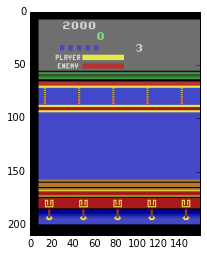

session # 0
 DOWNLEFT(qv = 0.0669251456857) -> 0.0 |  NOOP(qv = 0.0691706836224) -> 0.0 |  LEFTFIRE(qv = 0.371972292662) -> 0.0 |  LEFTFIRE(qv = 0.288203686476) -> 0.0 |  LEFTFIRE(qv = 0.255702674389) -> 0.0 |  RIGHTFIRE(qv = 0.0181918349117) -> 0.0 |  LEFTFIRE(qv = 0.283622801304) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0570411942899) -> 0.0 |  LEFTFIRE(qv = 0.316497296095) -> 0.0 |  NOOP(qv = 0.156362891197) -> 0.0 |  UPRIGHTFIRE(qv = 0.0131175173447) -> 0.0 |  LEFTFIRE(qv = 0.307959198952) -> 0.0 |  UP(qv = 0.0925384685397) -> 0.0 |  DOWNRIGHT(qv = 0.147814288735) -> 0.0 |  LEFTFIRE(qv = 0.266166687012) -> 0.0 |  UP(qv = 0.0699523836374) -> 0.0 |  LEFTFIRE(qv = 0.380390614271) -> 0.0 |  NOOP(qv = 0.0938759222627) -> 0.0 |  DOWNRIGHT(qv = 0.256932228804) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0527709312737) -> 0.0 |  DOWNRIGHT(qv = 0.334206968546) -> 0.0 |  DOWNRIGHT(qv = 0.405313372612) -> 0.0 |  DOWNRIGHT(qv = 0.344175100327) -> 0.0 |  UP(qv = 0.175228059292) -> 0.0 |  LEFTFIRE(qv = 0.324778825045) -

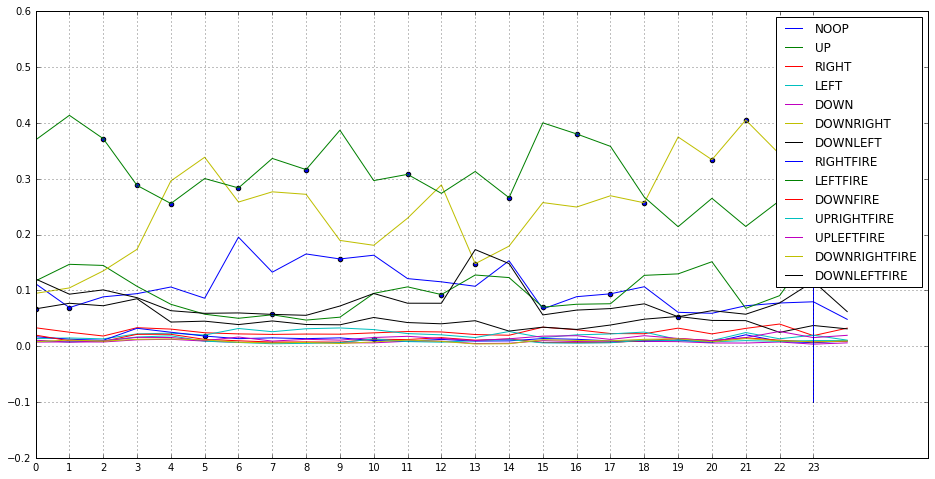

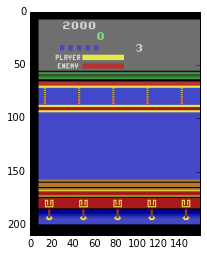

session # 0
 DOWNLEFT(qv = 0.0715296566486) -> 0.0 |  DOWNRIGHT(qv = 0.137455135584) -> 0.0 |  NOOP(qv = 0.101098932326) -> 0.0 |  UP(qv = 0.118737734854) -> 0.0 |  LEFTFIRE(qv = 0.250049978495) -> 0.0 |  DOWNLEFT(qv = 0.0541221089661) -> 0.0 |  LEFTFIRE(qv = 0.37613940239) -> 0.0 |  RIGHT(qv = 0.0200147088617) -> 0.0 |  DOWNFIRE(qv = 0.00752275204286) -> 0.0 |  LEFTFIRE(qv = 0.421958267689) -> 0.0 |  LEFTFIRE(qv = 0.395613104105) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0594150722027) -> 0.0 |  UP(qv = 0.12380296737) -> 0.0 |  LEFTFIRE(qv = 0.194714844227) -> 0.0 |  UP(qv = 0.0896990522742) -> 0.0 |  NOOP(qv = 0.106703646481) -> 0.0 |  LEFTFIRE(qv = 0.297830283642) -> 0.0 |  NOOP(qv = 0.112878270447) -> 0.0 |  LEFTFIRE(qv = 0.30776360631) -> 0.0 |  DOWNLEFT(qv = 0.0226430911571) -> 0.0 |  LEFTFIRE(qv = 0.323807954788) -> 0.0 |  NOOP(qv = 0.0967119634151) -> 0.0 |  LEFTFIRE(qv = 0.27396067977) -> 0.0 |  DOWNLEFTFIRE(qv = 0.106516562402) -> 0.0 |  LEFTFIRE(qv = 0.302269876003) -> 0.0 | reached max

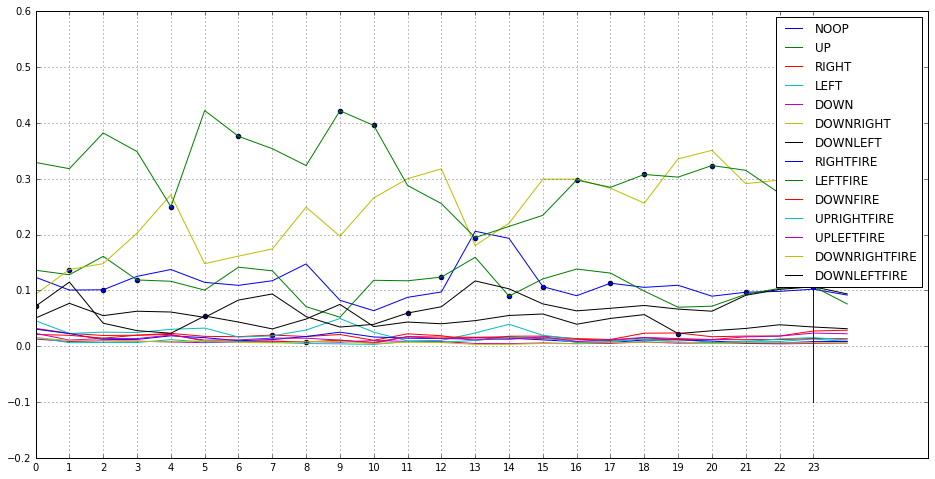

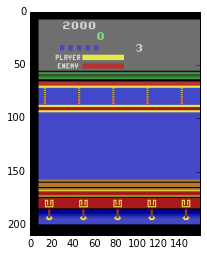

session # 0
 UP(qv = 0.166845753789) -> 0.0 |  RIGHTFIRE(qv = 0.0359800495207) -> 0.0 |  UPLEFTFIRE(qv = 0.0108813680708) -> 0.0 |  DOWNLEFT(qv = 0.0286585390568) -> 0.0 |  DOWNRIGHT(qv = 0.201331287622) -> 0.0 |  NOOP(qv = 0.106264986098) -> 0.0 |  LEFTFIRE(qv = 0.438281238079) -> 0.0 |  DOWNRIGHT(qv = 0.0860777646303) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0629243925214) -> 0.0 |  UP(qv = 0.08828189224) -> 0.0 |  DOWNRIGHT(qv = 0.2499884516) -> 0.0 |  DOWNRIGHT(qv = 0.255858659744) -> 0.0 |  LEFTFIRE(qv = 0.340071380138) -> 0.0 |  LEFTFIRE(qv = 0.322796106339) -> 0.0 |  DOWNRIGHT(qv = 0.13697373867) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0850386098027) -> 0.0 |  LEFTFIRE(qv = 0.313415139914) -> 0.0 |  NOOP(qv = 0.121296815574) -> 0.0 |  DOWNRIGHT(qv = 0.208673745394) -> 0.0 |  NOOP(qv = 0.186037525535) -> 0.0 |  LEFTFIRE(qv = 0.301642626524) -> 0.0 |  LEFTFIRE(qv = 0.278129070997) -> 0.0 |  DOWNRIGHT(qv = 0.227602630854) -> 0.0 |  DOWNRIGHT(qv = 0.240270510316) -> 0.0 |  LEFTFIRE(qv = 0.179784715176) 

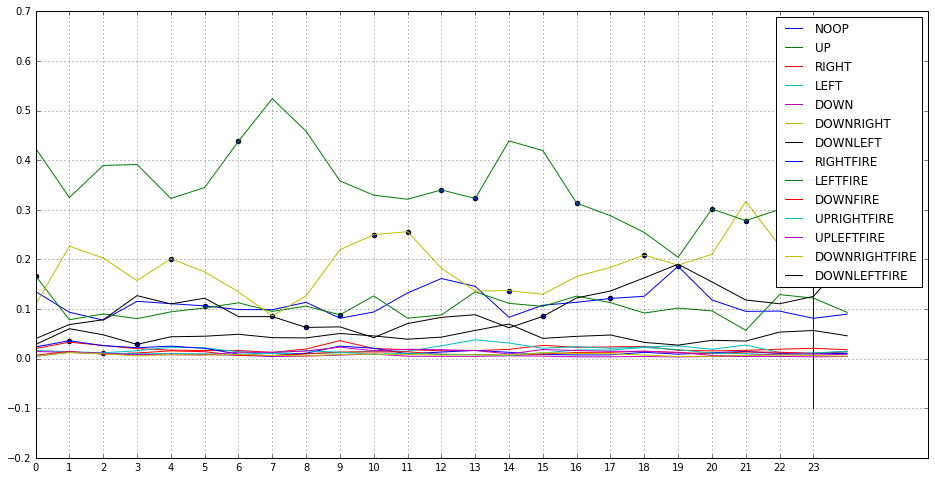

In [28]:
#visualize untrained network performance (which is mostly random)
display_sessions(with_plots=True)

# Training loop

In [29]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [30]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 50,loss 923.13395, epsilon 0.49109, rewards: ( e-greedy 2.00000, greedy 0.00000) 
rec 922.464 reg 0.670
epoch 100,loss 592.94993, epsilon 0.48236, rewards: ( e-greedy 3.80000, greedy 4.00000) 
rec 592.280 reg 0.670
epoch 150,loss 4.56736, epsilon 0.47379, rewards: ( e-greedy 3.42000, greedy 3.60000) 
rec 3.884 reg 0.683
epoch 200,loss 1479.05673, epsilon 0.46540, rewards: ( e-greedy 5.07800, greedy 4.24000) 
rec 1478.375 reg 0.682
epoch 250,loss 780.88050, epsilon 0.45718, rewards: ( e-greedy 6.57020, greedy 3.81600) 
rec 780.197 reg 0.683
epoch 300,loss 309.86157, epsilon 0.44911, rewards: ( e-greedy 6.91318, greedy 5.43440) 
rec 309.178 reg 0.684
epoch 350,loss 1638.60800, epsilon 0.44121, rewards: ( e-greedy 10.22186, greedy 14.89096) 
rec 1637.932 reg 0.676
epoch 400,loss 6.41076, epsilon 0.43346, rewards: ( e-greedy 9.19968, greedy 15.40186) 
rec 5.732 reg 0.679
epoch 450,loss 1525.12793, epsilon 0.42587, rewards: ( e-greedy 13.27971, greedy 15.86168) 
rec 1524.450 reg 0.678

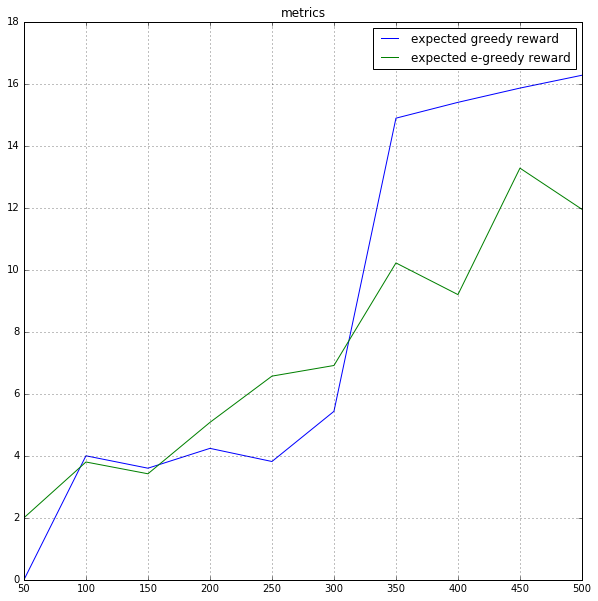

Random session examples


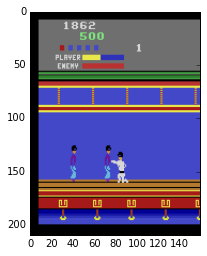

session # 0
 RIGHTFIRE(qv = 0.031631976366) -> 200.0 |  UP(qv = 0.0326662696898) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0667391866446) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0549227409065) -> 0.0 |  DOWNRIGHT(qv = 0.0616542585194) -> 0.0 |  DOWNLEFT(qv = 0.047812409699) -> 0.0 |  RIGHT(qv = 0.0495046451688) -> 0.0 |  DOWNLEFT(qv = 0.0455312654376) -> 0.0 |  UPLEFTFIRE(qv = 0.233486950397) -> 0.0 |  UPRIGHTFIRE(qv = 0.0714914798737) -> 0.0 |  UPLEFTFIRE(qv = 0.224638491869) -> 0.0 |  UP(qv = 0.0255620460957) -> 200.0 |  UPRIGHTFIRE(qv = 0.0542655810714) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0219361707568) -> 0.0 |  LEFTFIRE(qv = 0.0649191886187) -> 0.0 |  LEFT(qv = 0.202195599675) -> 0.0 |  RIGHT(qv = 0.0487850792706) -> 0.0 |  DOWNFIRE(qv = 0.072067193687) -> 0.0 |  UPLEFTFIRE(qv = 0.275127202272) -> 0.0 |  UPLEFTFIRE(qv = 0.315244406462) -> 0.0 |  LEFTFIRE(qv = 0.0780773609877) -> 0.0 |  UPLEFTFIRE(qv = 0.183060318232) -> 0.0 |  DOWNRIGHT(qv = 0.0707077756524) -> 0.0 |  RIGHT(qv = 0.0263945925981) -> 0.0 |  UP

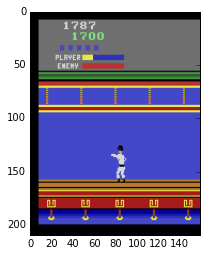

session # 0
 UPLEFTFIRE(qv = 0.250308632851) -> 0.0 |  UPRIGHTFIRE(qv = 0.0468438081443) -> 0.0 |  UPLEFTFIRE(qv = 0.304658770561) -> 0.0 |  LEFTFIRE(qv = 0.05991114676) -> 0.0 |  UPLEFTFIRE(qv = 0.265377372503) -> 0.0 |  UP(qv = 0.0246420949697) -> 0.0 |  DOWNRIGHT(qv = 0.0980192422867) -> 0.0 |  DOWNRIGHT(qv = 0.0858485549688) -> 0.0 |  DOWNLEFT(qv = 0.0391250364482) -> 0.0 |  LEFT(qv = 0.283549845219) -> 0.0 |  UP(qv = 0.0282708276063) -> 0.0 |  DOWNRIGHT(qv = 0.121153309941) -> 0.0 |  RIGHT(qv = 0.0344141386449) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0476426482201) -> 0.0 |  UPLEFTFIRE(qv = 0.320913106203) -> 0.0 |  UP(qv = 0.0435993261635) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0341879241168) -> 0.0 |  DOWNRIGHT(qv = 0.0968664065003) -> 0.0 |  UPRIGHTFIRE(qv = 0.0330238975585) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0498385950923) -> 0.0 |  UPLEFTFIRE(qv = 0.258465588093) -> 0.0 |  UPLEFTFIRE(qv = 0.226307988167) -> 0.0 |  DOWNLEFTFIRE(qv = 0.0595954507589) -> 0.0 |  LEFTFIRE(qv = 0.0482535660267) -> 0.0 |  

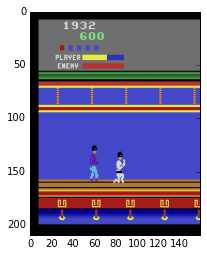

session # 0
 DOWNLEFTFIRE(qv = 0.0327111333609) -> 0.0 |  DOWNRIGHT(qv = 0.0880786702037) -> 0.0 |  UPLEFTFIRE(qv = 0.284680068493) -> 0.0 |  UPRIGHTFIRE(qv = 0.0415915884078) -> 0.0 |  NOOP(qv = 0.0301887970418) -> 0.0 |  DOWNFIRE(qv = 0.0668483451009) -> 0.0 |  LEFTFIRE(qv = 0.049958396703) -> 0.0 |  LEFTFIRE(qv = 0.048522669822) -> 0.0 |  LEFTFIRE(qv = 0.0657917335629) -> 0.0 |  UP(qv = 0.0243487693369) -> 0.0 |  DOWNRIGHT(qv = 0.0561762265861) -> 0.0 |  LEFT(qv = 0.175873011351) -> 0.0 |  RIGHTFIRE(qv = 0.0664663314819) -> 0.0 |  DOWNRIGHT(qv = 0.0941366478801) -> 0.0 |  LEFTFIRE(qv = 0.0673675835133) -> 0.0 |  RIGHTFIRE(qv = 0.06345243752) -> 0.0 |  DOWNRIGHT(qv = 0.101100899279) -> 0.0 |  DOWNRIGHT(qv = 0.091609954834) -> 0.0 |  LEFT(qv = 0.244539886713) -> 0.0 |  RIGHTFIRE(qv = 0.0516912266612) -> 0.0 |  LEFTFIRE(qv = 0.0738069564104) -> 0.0 |  UP(qv = 0.0272120833397) -> 0.0 |  RIGHTFIRE(qv = 0.0691591352224) -> 0.0 |  NOOP(qv = 0.0312495511025) -> 0.0 |  LEFT(qv = 0.2492789924

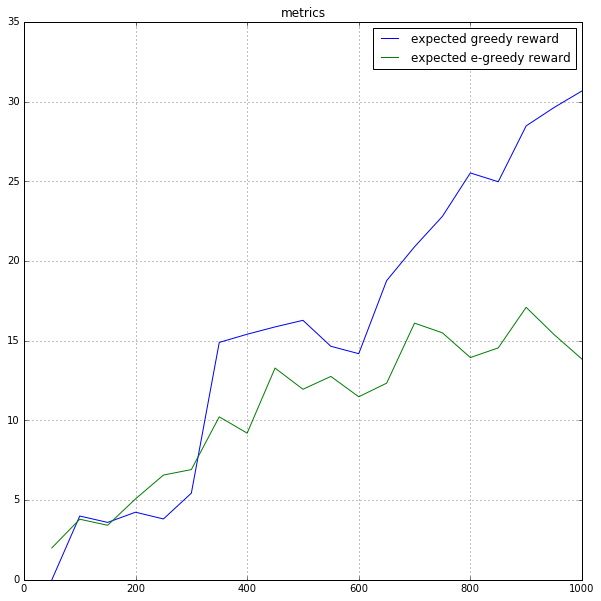

Random session examples


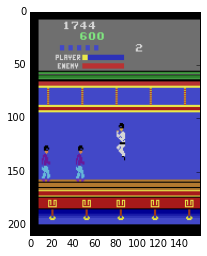

session # 0
 RIGHT(qv = 0.0349335931242) -> 0.0 |  LEFT(qv = 0.16851401329) -> 0.0 |  DOWNFIRE(qv = 0.0424014180899) -> 0.0 |  DOWNFIRE(qv = 0.0347173027694) -> 0.0 |  RIGHTFIRE(qv = 0.0414014309645) -> 0.0 |  DOWNRIGHT(qv = 0.0690378025174) -> 0.0 |  DOWNFIRE(qv = 0.051326636225) -> 0.0 |  DOWNRIGHT(qv = 0.0827432498336) -> 0.0 |  UPLEFTFIRE(qv = 0.306754678488) -> 0.0 |  UP(qv = 0.0305418819189) -> 0.0 |  RIGHTFIRE(qv = 0.0370132289827) -> 0.0 |  RIGHTFIRE(qv = 0.0444571338594) -> 0.0 |  DOWNLEFTFIRE(qv = 0.105139270425) -> 0.0 |  DOWNRIGHT(qv = 0.0735968649387) -> 0.0 |  UPLEFTFIRE(qv = 0.259644091129) -> 0.0 |  UPRIGHTFIRE(qv = 0.0504407659173) -> 0.0 |  RIGHTFIRE(qv = 0.0286817550659) -> 0.0 |  UPLEFTFIRE(qv = 0.211674705148) -> 0.0 |  RIGHTFIRE(qv = 0.0413404628634) -> 0.0 |  UPLEFTFIRE(qv = 0.236894160509) -> 0.0 |  NOOP(qv = 0.0135072963312) -> 0.0 |  DOWN(qv = 0.0199856106192) -> 0.0 |  UPLEFTFIRE(qv = 0.273014187813) -> 0.0 |  DOWN(qv = 0.0241713952273) -> 0.0 |  DOWNRIGHT(qv

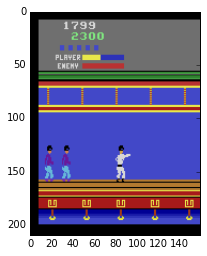

session # 0
 DOWNLEFT(qv = 0.0469518303871) -> 0.0 |  LEFT(qv = 0.159159600735) -> 0.0 |  RIGHTFIRE(qv = 0.0402559936047) -> 0.0 |  DOWNRIGHT(qv = 0.068531781435) -> 0.0 |  LEFTFIRE(qv = 0.0960552245378) -> 0.0 |  UPLEFTFIRE(qv = 0.229429528117) -> 0.0 |  RIGHT(qv = 0.036262691021) -> 0.0 |  UP(qv = 0.0372490175068) -> 0.0 |  LEFT(qv = 0.179621770978) -> 0.0 |  LEFTFIRE(qv = 0.0980636104941) -> 0.0 |  RIGHT(qv = 0.0249417517334) -> 0.0 |  UP(qv = 0.0357351191342) -> 0.0 |  UPLEFTFIRE(qv = 0.241546481848) -> 0.0 |  RIGHT(qv = 0.0372387431562) -> 0.0 |  RIGHT(qv = 0.0333422124386) -> 0.0 |  DOWNFIRE(qv = 0.0315134711564) -> 0.0 |  DOWNLEFTFIRE(qv = 0.122807398438) -> 0.0 |  DOWNFIRE(qv = 0.044064220041) -> 0.0 |  UPLEFTFIRE(qv = 0.243925616145) -> 0.0 |  RIGHTFIRE(qv = 0.0541774183512) -> 0.0 |  LEFT(qv = 0.160461455584) -> 0.0 |  UPRIGHTFIRE(qv = 0.0425159670413) -> 0.0 |  LEFT(qv = 0.168907061219) -> 0.0 |  UPLEFTFIRE(qv = 0.257189124823) -> 0.0 |  UPLEFTFIRE(qv = 0.25718909502) -> 0.0

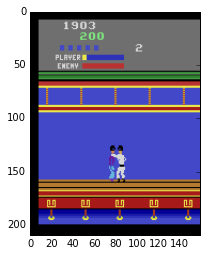

session # 0
 UP(qv = 0.0481719747186) -> 0.0 |  UPRIGHTFIRE(qv = 0.0460908934474) -> 0.0 |  UPRIGHTFIRE(qv = 0.061587177217) -> 0.0 |  DOWN(qv = 0.0128878895193) -> 0.0 |  UPLEFTFIRE(qv = 0.300490885973) -> 0.0 |  DOWNLEFT(qv = 0.0441386923194) -> 0.0 |  UPLEFTFIRE(qv = 0.276608288288) -> 0.0 |  UP(qv = 0.029261149466) -> 0.0 |  LEFTFIRE(qv = 0.100952297449) -> 0.0 |  DOWNLEFT(qv = 0.0383951291442) -> 0.0 |  UPRIGHTFIRE(qv = 0.0359103083611) -> 0.0 |  LEFT(qv = 0.216171532869) -> 0.0 |  LEFTFIRE(qv = 0.137001022696) -> 0.0 |  RIGHT(qv = 0.0189298465848) -> 0.0 |  DOWNRIGHT(qv = 0.061347939074) -> 0.0 |  LEFTFIRE(qv = 0.101020954549) -> 0.0 |  DOWNLEFT(qv = 0.0408731177449) -> 0.0 |  UPRIGHTFIRE(qv = 0.0516959242523) -> 0.0 |  LEFT(qv = 0.129456862807) -> 0.0 |  RIGHT(qv = 0.0257091894746) -> 0.0 |  NOOP(qv = 0.0119536789134) -> 0.0 |  LEFT(qv = 0.160645887256) -> 0.0 |  UPLEFTFIRE(qv = 0.241728633642) -> 0.0 |  RIGHTFIRE(qv = 0.0630081295967) -> 0.0 |  LEFTFIRE(qv = 0.0848568379879) ->

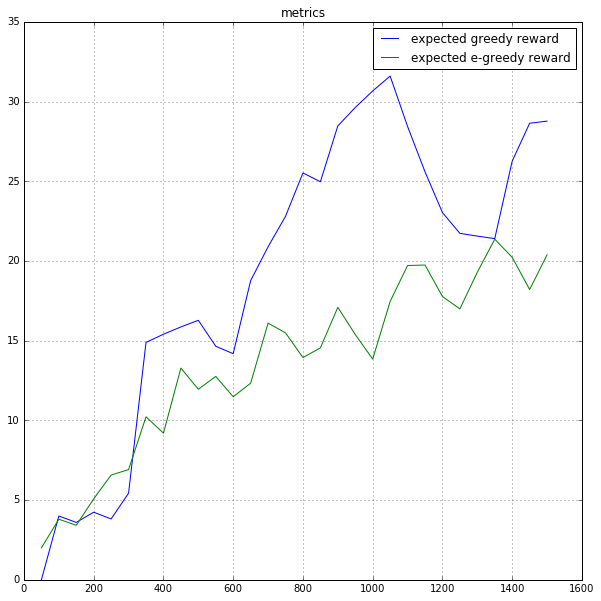

Random session examples


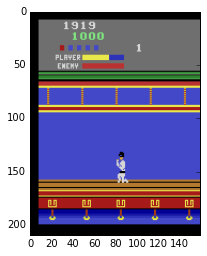

session # 0
 DOWNLEFTFIRE(qv = 0.135384991765) -> 0.0 |  DOWNRIGHT(qv = 0.0456457436085) -> 0.0 |  DOWNFIRE(qv = 0.0529396906495) -> 0.0 |  DOWNLEFTFIRE(qv = 0.188983231783) -> 0.0 |  DOWNFIRE(qv = 0.0458343699574) -> 0.0 |  DOWNRIGHT(qv = 0.0677718296647) -> 0.0 |  UPLEFTFIRE(qv = 0.228252828121) -> 0.0 |  DOWNLEFTFIRE(qv = 0.111911714077) -> 0.0 |  DOWNRIGHT(qv = 0.083774343133) -> 0.0 |  UPRIGHTFIRE(qv = 0.0374771095812) -> 0.0 |  UPRIGHTFIRE(qv = 0.0409388318658) -> 0.0 |  DOWNLEFTFIRE(qv = 0.148138314486) -> 0.0 |  NOOP(qv = 0.0148333199322) -> 0.0 |  LEFTFIRE(qv = 0.109595030546) -> 0.0 |  UPLEFTFIRE(qv = 0.271507263184) -> 0.0 |  UPLEFTFIRE(qv = 0.250498116016) -> 0.0 |  UP(qv = 0.0377871766686) -> 0.0 |  LEFTFIRE(qv = 0.114643029869) -> 0.0 |  UPRIGHTFIRE(qv = 0.0374771021307) -> 0.0 |  UPRIGHTFIRE(qv = 0.0323671735823) -> 0.0 |  UP(qv = 0.0207343827933) -> 0.0 |  UPLEFTFIRE(qv = 0.231130942702) -> 0.0 |  UPLEFTFIRE(qv = 0.212304338813) -> 0.0 |  UPLEFTFIRE(qv = 0.278865218163)

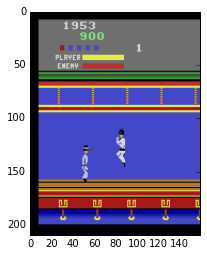

session # 0
 DOWNLEFT(qv = 0.0737012326717) -> 0.0 |  DOWNLEFTFIRE(qv = 0.16889475286) -> 0.0 |  DOWNRIGHTFIRE(qv = 0.0139992237091) -> 0.0 |  DOWN(qv = 0.0335187464952) -> 0.0 |  LEFT(qv = 0.120399475098) -> 0.0 |  LEFTFIRE(qv = 0.118616364896) -> 0.0 |  UP(qv = 0.0231920853257) -> 0.0 |  LEFTFIRE(qv = 0.0815447792411) -> 0.0 |  DOWNLEFT(qv = 0.089288495481) -> 0.0 |  DOWNLEFTFIRE(qv = 0.146615430713) -> 0.0 |  LEFTFIRE(qv = 0.0901019349694) -> 0.0 |  UPLEFTFIRE(qv = 0.189085289836) -> 0.0 |  UPLEFTFIRE(qv = 0.206680238247) -> 0.0 |  DOWNLEFT(qv = 0.0808925926685) -> 0.0 |  LEFTFIRE(qv = 0.0888646990061) -> 0.0 |  LEFT(qv = 0.148762330413) -> 0.0 |  DOWNRIGHT(qv = 0.0768350064754) -> 0.0 |  DOWNRIGHT(qv = 0.0768387839198) -> 0.0 |  DOWNLEFTFIRE(qv = 0.1386782974) -> 0.0 |  DOWNRIGHT(qv = 0.0768349766731) -> 0.0 |  LEFT(qv = 0.148070678115) -> 0.0 |  DOWNRIGHT(qv = 0.0695628076792) -> 0.0 |  UPLEFTFIRE(qv = 0.129194527864) -> 0.0 |  DOWN(qv = 0.0335813723505) -> 0.0 |  UP(qv = 0.019941

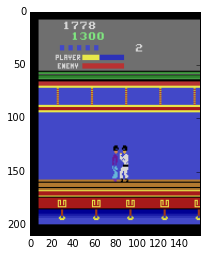

session # 0
 RIGHTFIRE(qv = 0.0277352519333) -> 0.0 |  NOOP(qv = 0.0114976223558) -> 0.0 |  UPRIGHTFIRE(qv = 0.0480512939394) -> 0.0 |  UP(qv = 0.0203826092184) -> 0.0 |  UPRIGHTFIRE(qv = 0.0412028953433) -> 0.0 |  LEFT(qv = 0.125856935978) -> 0.0 |  UPRIGHTFIRE(qv = 0.0412028953433) -> 0.0 |  RIGHT(qv = 0.0555154047906) -> 0.0 |  DOWNFIRE(qv = 0.0538217835128) -> 0.0 |  DOWNLEFT(qv = 0.0667387247086) -> 0.0 |  DOWN(qv = 0.0287150721997) -> 0.0 |  UP(qv = 0.0256692189723) -> 0.0 |  DOWNLEFTFIRE(qv = 0.156895548105) -> 0.0 |  LEFT(qv = 0.125856950879) -> 0.0 |  DOWNLEFTFIRE(qv = 0.156821861863) -> 0.0 |  DOWNLEFT(qv = 0.0667387247086) -> 0.0 |  UPLEFTFIRE(qv = 0.222339123487) -> 0.0 |  DOWNFIRE(qv = 0.0537811554968) -> 0.0 |  LEFT(qv = 0.126688629389) -> 0.0 |  LEFTFIRE(qv = 0.0992620140314) -> 0.0 |  DOWNLEFTFIRE(qv = 0.165885448456) -> 0.0 |  LEFTFIRE(qv = 0.0814123526216) -> 0.0 |  LEFTFIRE(qv = 0.0814094096422) -> 0.0 |  DOWNLEFT(qv = 0.0668960362673) -> 0.0 |  UPLEFTFIRE(qv = 0.203

In [ ]:
n_epochs = 10000
batch_size= 10

for i in range(n_epochs):    
    
    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/2500.)
        epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %500 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %1000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print("saved", snap_name)

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials
 * we took epoch 7k for final submission
 * done via `load(resolver,"./agentnet_snapshots/{your experiment_setup_name}.epoch7000.pcl")`

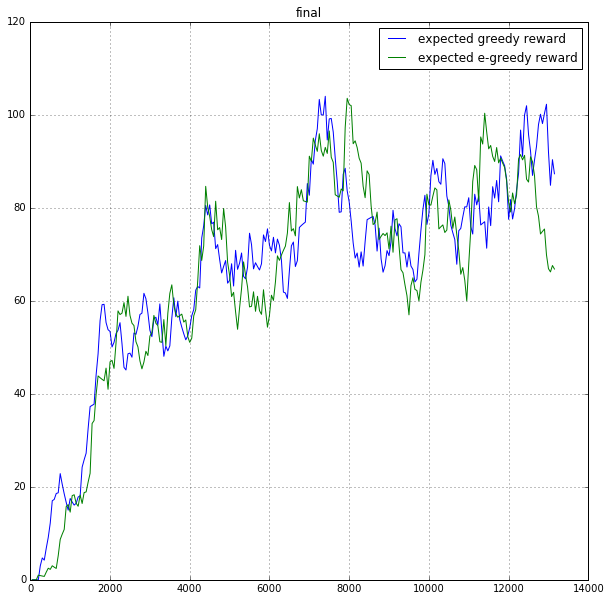

In [35]:
score_log.plot("final")

Random session examples


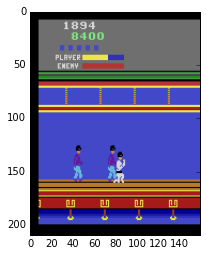

session # 0
 DOWN(qv = 0.209978818893) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235172405839) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235172405839) -> 0.0 |  DOWN(qv = 0.256403476) -> 200.0 |  DOWNRIGHT(qv = 0.0358445718884) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235172405839) -> 0.0 |  DOWNLEFTFIRE(qv = 0.3447496593) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  RIGHT(qv = 0.0438031703234) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  LEFT(qv = 0.0747688040137) -> 0.0 |  DOWN(qv = 0.256403476) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235172405839) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 |  RIGHT(qv = 0.0438031703234) -> 0.0 |  UPLEFTFIRE(qv = 0.302690476179) -> 0.0 | reached ma

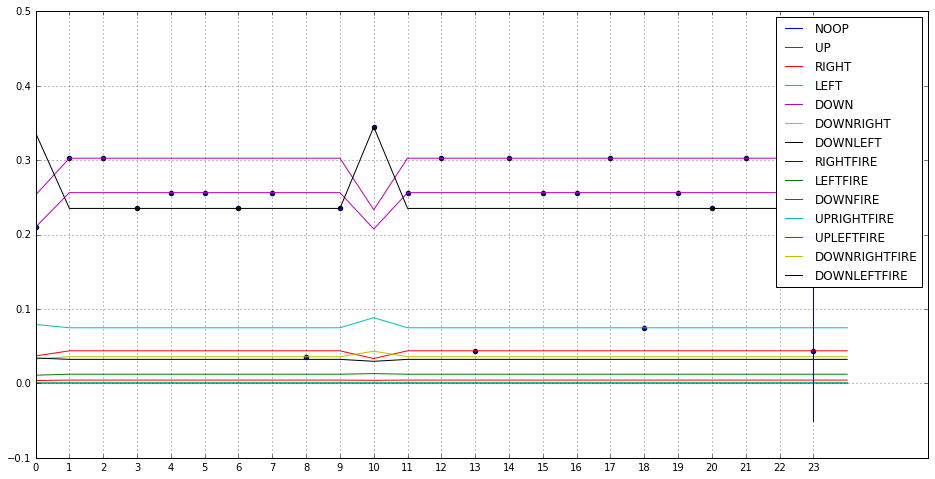

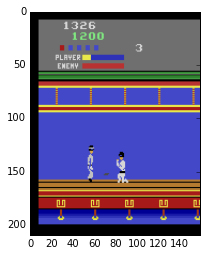

session # 0
 LEFT(qv = 0.0794909521937) -> 0.0 |  DOWNLEFT(qv = 0.0323165617883) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  DOWNRIGHT(qv = 0.035844437778) -> 0.0 |  DOWN(qv = 0.256388962269) -> 0.0 |  DOWNRIGHT(qv = 0.035844437778) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235168173909) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235168173909) -> 0.0 |  DOWNLEFT(qv = 0.0323165617883) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  DOWN(qv = 0.256388962269) -> 0.0 |  LEFT(qv = 0.0747636556625) -> 0.0 |  DOWNRIGHT(qv = 0.035844437778) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235168173909) -> 0.0 |  DOWN(qv = 0.256388962269) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235168173909) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  LEFT(qv = 0.0747636556625) -> 0.0 |  RIGHT(qv = 0.0438134670258) -> 0.0 |  UPLEFTFIRE(qv = 0.302703469992) -> 0.0 |  DOWN(qv = 0.256388962269) -> 0.0 |  UPLEFTFIRE(qv = 0.3

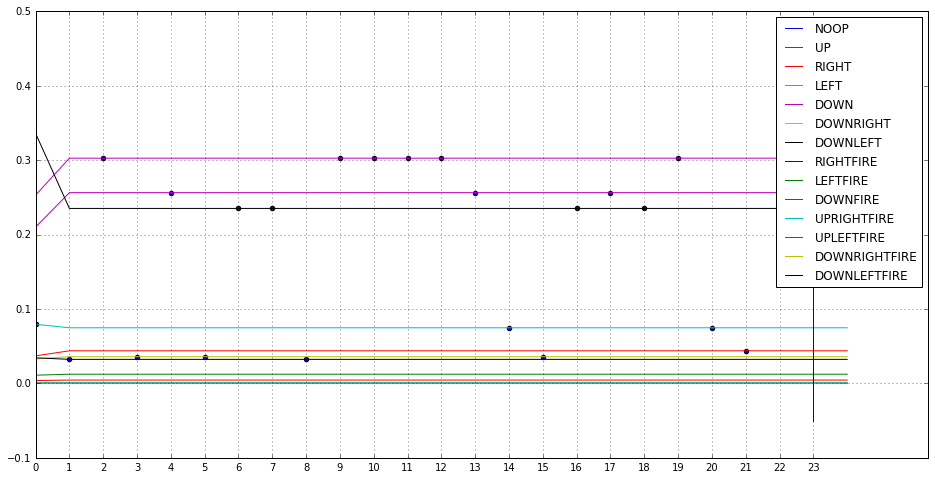

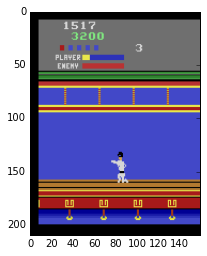

session # 0
 DOWNLEFTFIRE(qv = 0.33404481411) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171437263) -> 0.0 |  DOWN(qv = 0.255167156458) -> 0.0 |  DOWN(qv = 0.255167156458) -> 0.0 |  LEFT(qv = 0.0747660771012) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171437263) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  RIGHT(qv = 0.0438035652041) -> 0.0 |  DOWN(qv = 0.255167156458) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  DOWNRIGHT(qv = 0.0358428172767) -> 0.0 |  UPLEFTFIRE(qv = 0.302700221539) -> 0.0 |  DOWNLEFTFIRE(qv = 0.235171437263) -> 0.0 |  DOWN(qv = 0.25640052557) -> 0.0 |  DOWNRIGHT(qv = 0.0358428172767) -> 0.0 | reached

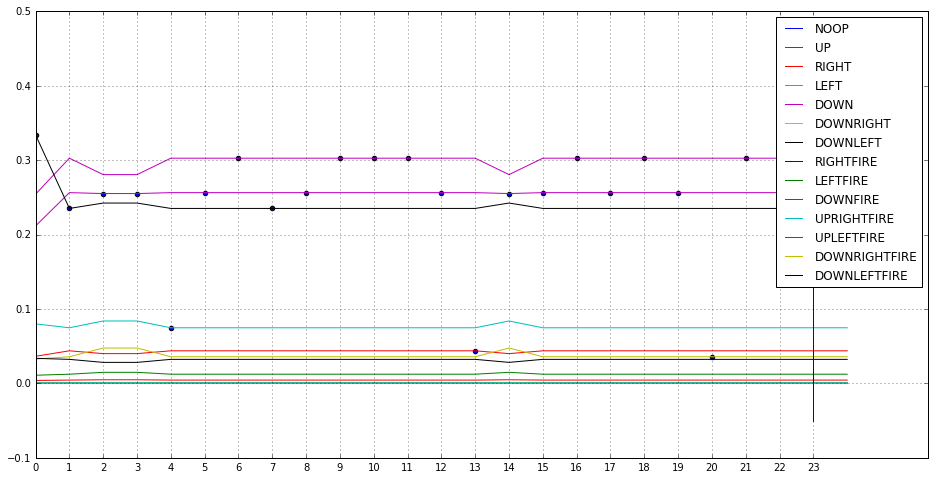

In [39]:
print "Random session examples"
display_sessions(with_plots=True)


# Submission

In [40]:
epsilon.set_value(0)

In [ ]:

save_path = '/tmp/AgentNet-simplenet-kungfu-v0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
#subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(200):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = [np.zeros((1,)+tuple(mem.output_shape[1:]),dtype=floatX) 
                         for mem in agent.state_variables]
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories)
        observation, reward, done, info = subm_env.step(action)
        
        prev_memories = new_memories
        if done:
            print "Episode finished after {} timesteps".format(t+1)
            break
        t+=1

subm_env.monitor.close()

In [47]:
gym.monitoring._monitors.clear()

In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)
